# Project description

Sweet Lift Taxi company has collected historical data on taxi orders at airports. To attract more drivers during peak hours, we need to predict the amount of taxi orders for the next hour. Build a model for such a prediction.

The RMSE metric on the test set should not be more than 48.

## Project instructions

1. Download the data and resample it by one hour.
2. Analyze the data.
3. Train different models with different hyperparameters. The test sample should be 10% of the initial dataset. 
4. Test the data using the test sample and provide a conclusion.

## Data description

The data is stored in file `taxi.csv`. The number of orders is in the '*num_orders*' column.

## Preparation

In [1]:
import pandas as pd
import numpy as np
import lightgbm as lgb

from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split, RandomizedSearchCV, TimeSeriesSplit, GridSearchCV
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import arma_order_select_ic
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.dummy import DummyRegressor

In [2]:
df = pd.read_csv('C:/Users/cmram/Downloads/taxi.csv', parse_dates=[0], index_col=[0])

In [3]:
df.sort_index(inplace=True)
df = df.resample('1H').sum()
display(df.head(10))
display(df.info())
display(df.describe())

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43
2018-03-01 05:00:00,6
2018-03-01 06:00:00,12
2018-03-01 07:00:00,15
2018-03-01 08:00:00,34


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


None

,num_orders
count,4416.000000
mean,84.422781
std,45.023853
min,0.000000
25%,54.000000
50%,78.000000
75%,107.000000
max,462.000000


In [4]:
df.isna().sum()

num_orders    0
dtype: int64

In [5]:
df.duplicated().sum()

4165

<Axes: xlabel='datetime'>

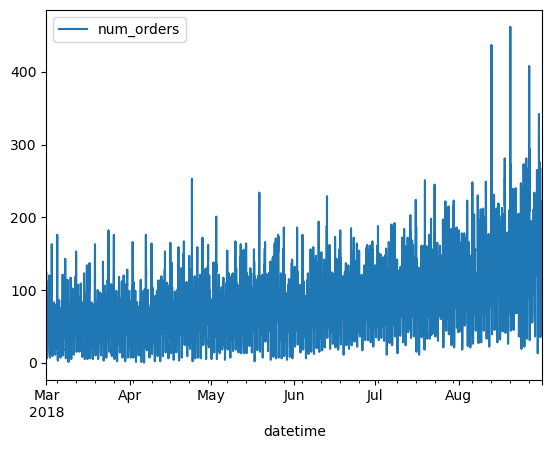

In [6]:
df.plot()

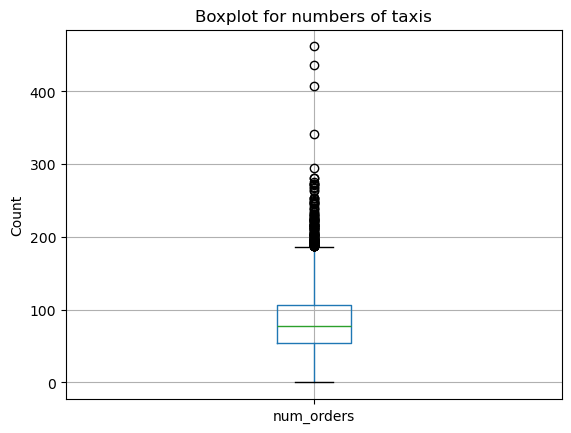

In [7]:
df.boxplot()

plt.title('Boxplot for numbers of taxis')
plt.ylabel('Count')
plt.show()

In [8]:
Q1 = df['num_orders'].quantile(0.25)
Q3 = df['num_orders'].quantile(0.75)
IQR = Q3 - Q1

# Define outliers
lower_bound = Q1 - 2 * IQR
upper_bound = Q3 + 2 * IQR

outliers = df[(df['num_orders'] < lower_bound) | (df['num_orders'] > upper_bound)]

print(f"Number of Outliers: {len(outliers)}")

Number of Outliers: 59


In [9]:
df = df[(df['num_orders'] <= 250)]

print("Data after Replacing Outliers:\n", df.describe())

Data after Replacing Outliers:
         num_orders
count  4396.000000
mean     83.453822
std      42.563995
min       0.000000
25%      54.000000
50%      78.000000
75%     107.000000
max     249.000000


Removed any outliers above 250. 250 taxis in 1 hour still seems high but could be possible on holidays at a busy airport

## Analysis

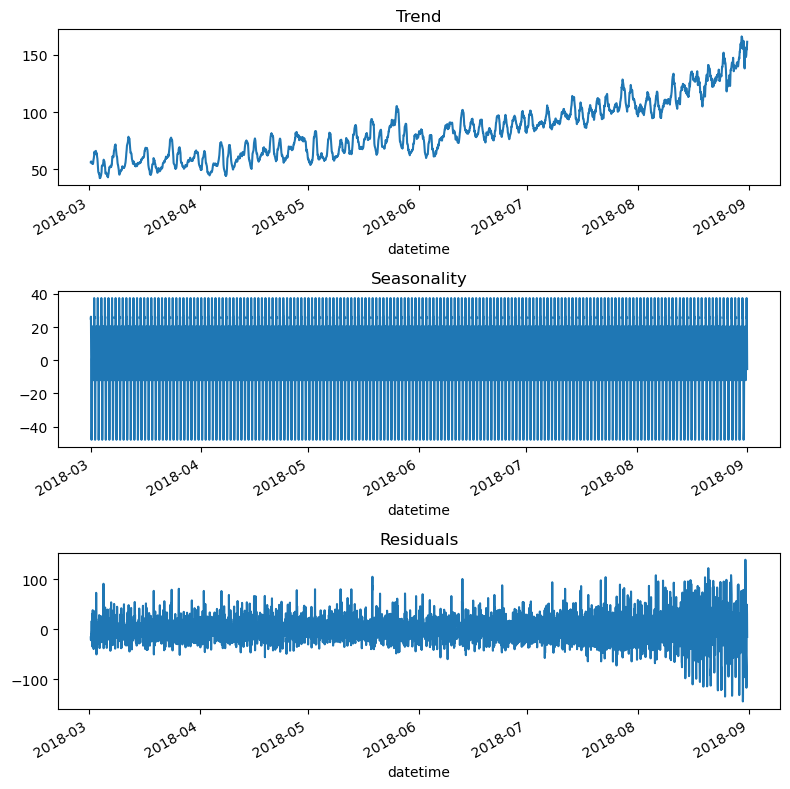

In [10]:
decomposed = seasonal_decompose(df, period = 24)

plt.figure(figsize=(8, 8))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')

plt.tight_layout()

We see our trend is there is more drivers needed the closer to summer you get.

C:\Users\cmram\AppData\Local\Temp\ipykernel_18508\1787191843.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['mean'] = df['num_orders'].shift(1).rolling(4).mean()
C:\Users\cmram\AppData\Local\Temp\ipykernel_18508\1787191843.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['std'] = df['num_orders'].shift(1).rolling(24).std()


<Axes: xlabel='datetime'>

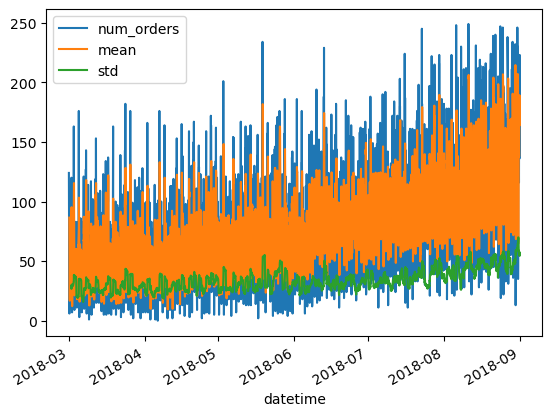

In [11]:
df['mean'] = df['num_orders'].shift(1).rolling(4).mean()
df['std'] = df['num_orders'].shift(1).rolling(24).std()
df.plot()

The mean follows the increasing trend. 

The standard deviation grows over time, suggesting increased variability in order numbers as time progresses.

<Axes: xlabel='datetime'>

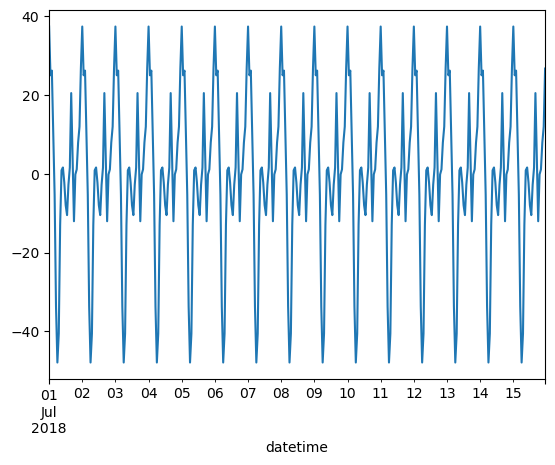

In [12]:
decomposed.seasonal['2018-07-01':'2018-07-15'].plot()

This shows a repeating pattern within each day, indicating a strong daily seasonality.This shows our taxi orders peak during rush hour and decreases late at night.

In [13]:
def make_features(df, max_lag, rolling_mean_size):
    df['hour'] = df.index.hour
    df['month'] = df.index.month
    df['day'] = df.index.day
    df['dayofweek'] = df.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        df['lag_{}'.format(lag)] = df['num_orders'].shift(lag)

    df['rolling_mean'] = (
        df['num_orders'].shift().rolling(rolling_mean_size).mean()
    )

make_features(df, 4, 4)
print(df.head())

                     num_orders  mean  std  hour  month  day  dayofweek  \
datetime                                                                  
2018-03-01 00:00:00         124   NaN  NaN     0      3    1          3   
2018-03-01 01:00:00          85   NaN  NaN     1      3    1          3   
2018-03-01 02:00:00          71   NaN  NaN     2      3    1          3   
2018-03-01 03:00:00          66   NaN  NaN     3      3    1          3   
2018-03-01 04:00:00          43  86.5  NaN     4      3    1          3   

                     lag_1  lag_2  lag_3  lag_4  rolling_mean  
datetime                                                       
2018-03-01 00:00:00    NaN    NaN    NaN    NaN           NaN  
2018-03-01 01:00:00  124.0    NaN    NaN    NaN           NaN  
2018-03-01 02:00:00   85.0  124.0    NaN    NaN           NaN  
2018-03-01 03:00:00   71.0   85.0  124.0    NaN           NaN  
2018-03-01 04:00:00   66.0   71.0   85.0  124.0          86.5  


C:\Users\cmram\AppData\Local\Temp\ipykernel_18508\247691582.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['hour'] = df.index.hour
C:\Users\cmram\AppData\Local\Temp\ipykernel_18508\247691582.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['month'] = df.index.month
C:\Users\cmram\AppData\Local\Temp\ipykernel_18508\247691582.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats i

In [14]:
df.isna().sum()

num_orders       0
mean             4
std             24
hour             0
month            0
day              0
dayofweek        0
lag_1            1
lag_2            2
lag_3            3
lag_4            4
rolling_mean     4
dtype: int64

In [15]:
df = df.dropna()

In [16]:
df.isna().sum()

num_orders      0
mean            0
std             0
hour            0
month           0
day             0
dayofweek       0
lag_1           0
lag_2           0
lag_3           0
lag_4           0
rolling_mean    0
dtype: int64

## Training

In [17]:
features = df.drop(['num_orders'], axis=1)
target = df['num_orders']

In [18]:
features_train, features_combine, target_train, target_combine = train_test_split(features,target, 
                                              train_size=0.8, 
                                              random_state=12345,
                                              shuffle=False) 

features_val, features_test, target_val, target_test = train_test_split(features_combine, 
                                                target_combine, 
                                                test_size=0.5, 
                                                random_state=12345,
                                                shuffle=False) 

print(features_train.index.min(), features_train.index.max())

print(features_val.index.min(), features_val.index.max())

print(features_test.index.min(), features_test.index.max())

2018-03-02 00:00:00 2018-07-25 18:00:00
2018-07-25 19:00:00 2018-08-12 23:00:00
2018-08-13 00:00:00 2018-08-31 23:00:00


**Linear Regression**

In [19]:
combined_train = features_train.join(target_train).dropna()

features_train_clean = combined_train.drop(columns='num_orders')
target_train_clean = combined_train['num_orders']

lr_model = LinearRegression()

lr_model.fit(features_train_clean, target_train_clean)

pred_train = lr_model.predict(features_train_clean)
pred_val = lr_model.predict(features_val.dropna())  

print("RMSE for the training set:", mean_squared_error(target_train_clean, pred_train, squared=False))
print("RMSE for the val set: ", mean_squared_error(target_val.dropna(), pred_val, squared=False))

RMSE for the training set: 28.666330896492333
RMSE for the val set:  38.398124683434574


A good model to look at for reference as to how other models compare

**AutoRegression**

In [20]:
res = arma_order_select_ic(y=target_train, max_ar=0, max_ma=10)
ma_order = res.bic_min_order[1] 

ma_model = ARIMA(target_train, order=(0, 0, ma_order))
ma_model = ma_model.fit()

start_value = len(target_train)
end_value = start_value + len(features_val) - 1
ma_pred = ma_model.predict(start=start_value, end=end_value, dynamic=False)

ma_rmse_value = mean_squared_error(target_val, ma_pred, squared=False)
print(ma_rmse_value)

c:\Users\cmram\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\cmram\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\cmram\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


55.10190564458446


c:\Users\cmram\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\cmram\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


**Random Forest**

In [21]:
rf_model = RandomForestRegressor(n_estimators=20, max_depth=5, n_jobs=1, random_state=12345)
rf_model.fit(features_train_clean, target_train_clean)
rf_preds = rf_model.predict(features_val.dropna())
rf_rmse = mean_squared_error(target_val.dropna(), rf_preds, squared=False)
print("Random Forest RMSE:", rf_rmse)

Random Forest RMSE: 34.88540337827593


In [22]:
param_grid = {
    'n_estimators': [30, 50, 100],
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 5, 7],
}

tscv = TimeSeriesSplit(n_splits=4)

grid_search = GridSearchCV(estimator=RandomForestRegressor(), param_grid=param_grid, cv=tscv, n_jobs=-1, verbose=2, scoring='neg_root_mean_squared_error')

In [23]:
grid_search.fit(features_train_clean, target_train_clean)

best_params = grid_search.best_params_
print("Best Parameters:", best_params)

Fitting 4 folds for each of 27 candidates, totalling 108 fits
Best Parameters: {'max_depth': 15, 'min_samples_split': 7, 'n_estimators': 50}


In [24]:
best_rf_model = RandomForestRegressor(n_estimators=30, max_depth=15, n_jobs=1, min_samples_split=7, random_state=12345)
best_rf_model.fit(features_train_clean, target_train_clean)
best_rf_preds = best_rf_model.predict(features_val.dropna())
best_rf_rmse = mean_squared_error(target_val.dropna(), best_rf_preds, squared=False)
print("Random Forest RMSE:", best_rf_rmse)

Random Forest RMSE: 29.652710835212616


**LightGBM Regressor**

In [25]:
lgb_model = lgb.LGBMRegressor()
lgb_model.fit(features_train_clean, target_train_clean)
lgb_preds = lgb_model.predict(features_val.dropna())
lgb_rmse = mean_squared_error(target_val.dropna(), lgb_preds, squared=False)
print("LightGBM RMSE:", lgb_rmse)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000294 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1534
[LightGBM] [Info] Number of data points in the train set: 3497, number of used features: 11
[LightGBM] [Info] Start training from score 74.191021
LightGBM RMSE: 30.2182995795


In [26]:
param_dist = {
    'num_leaves': [31, 40, 50],
    'max_depth': [10, 20, 30],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [100, 200, 300]
}

lgb_search = RandomizedSearchCV(
    estimator=lgb_model,
    param_distributions=param_dist,
    n_iter=3,
    scoring='neg_root_mean_squared_error',
    cv=tscv,
    random_state=12345,
    n_jobs=-1
)

In [27]:
lgb_search.fit(features_train_clean, target_train_clean)

print("Best Parameters:", lgb_search.best_params_)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000154 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1534
[LightGBM] [Info] Number of data points in the train set: 3497, number of used features: 11
[LightGBM] [Info] Start training from score 74.191021
Best Parameters: {'num_leaves': 31, 'n_estimators': 100, 'max_depth': 30, 'learning_rate': 0.1}


In [28]:
best_lgb_model = lgb.LGBMRegressor(num_leaves=31, n_estimators=100, max_depth=30, learning_rate=0.1)
best_lgb_model.fit(features_train_clean, target_train_clean)
best_lgb_preds = best_lgb_model.predict(features_val.dropna())
best_lgb_rmse = mean_squared_error(target_val.dropna(), best_lgb_preds, squared=False)
print("LightGBM RMSE:", best_lgb_rmse)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000155 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1534
[LightGBM] [Info] Number of data points in the train set: 3497, number of used features: 11
[LightGBM] [Info] Start training from score 74.191021
LightGBM RMSE: 30.2182995795


We had 2 very good models both the Random Forest and the LightGBM. They were only 1 point away from each other. We will run both in the test to see how they preform.

## Testing

In [29]:
dummy_regressor = DummyRegressor(strategy='mean')
dummy_regressor.fit(features_test, target_test)

dummy_pred = dummy_regressor.predict(features_test.dropna())

dummy_rmse = mean_squared_error(target_test.dropna(), dummy_pred, squared=False)
print("Dummy RMSE:", dummy_rmse)

Dummy RMSE: 49.656625195059306


In [30]:
best_model = lgb.LGBMRegressor(num_leaves=31, n_estimators=100, max_depth=30, learning_rate=0.1)
best_model.fit(features_test, target_test)
best_preds = best_model.predict(features_test.dropna())
best_rmse = mean_squared_error(target_test.dropna(), best_preds, squared=False)
print("Test LightGBM RMSE:", best_rmse)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000056 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 942
[LightGBM] [Info] Number of data points in the train set: 438, number of used features: 10
[LightGBM] [Info] Start training from score 133.214612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

In [31]:
test_rf_model = RandomForestRegressor(n_estimators=30, max_depth=15, n_jobs=1, min_samples_split=7, random_state=12345)
test_rf_model.fit(features_test, target_test)
test_rf_preds = test_rf_model.predict(features_test.dropna())
test_rf_rmse = mean_squared_error(target_test.dropna(), test_rf_preds, squared=False)
print("Test Random Forest RMSE:", test_rf_rmse)

Test Random Forest RMSE: 16.68799047387975


## Conclusion

Sweet Lift Taxi company has tasked us with creating a machine learning model to look at historical data on taxi orders at airports and predict the amount of taxi orders for the next hour to attract more drivers during that time.

**PreProcessing**
- We indexed our data
- We looked at our data to make sure we had no outliers that would skew our models
- We checked for duplicates and NA data but didn't find any
- We added our extra columns before we split the data 

**Model Training** 
- We trained a Linear Regression to give us a baseline model to refer back to
- We trained and tuned a Auto Regression model which gave us RSME of 55. This was higher than our required 48 
- We tested a dummy regressor to compare to our best model with an RMSE of 49. Close to the required 48 but much worse than our LightGBM model
- We trained a LightGBM model and with the best hyperparameters we get a RMSE of 30 in the train and a 12 in test. Our Random forest did better in the training with a RMSE of 29 but not as well in the test with a RMSE of 16. These were both lower than the required 48. This gives us a very accurate account of how many taxis orders will be made in the next hour